# Assignment : Autonomous Driving (Part 2)

In this assignment, the goal is to use the training data from the assignment Autonomous Driving (Part 1) for learning to drive autonomously. For that reason, We will use the car racing example from [Gymnasium](https://gymnasium.farama.org). As we show in the last assignment, Gym is a framework for developing reinforcement learning approaches. It supports different types of agents. Here, we will focus on vehicles.

*Important*: You need to install [Gymnasium](https://gymnasium.farama.org) in your system. The installation can be done with pip or by installing from the sources. More information at [https://pypi.org/project/gymnasium/](https://pypi.org/project/gymnasium/)).



## 1. Car Racing Model Learning

In this exercise, a car drives a route in a racing environment. The car can turn left, right, accelerate or decelerate. The input is an image with 96x96 pixels. In addition, rewards are given based on the driving behavior. We are not interested in the rewards in this task. The task of this exercise is to make use of training data from the Assignment 3 to train a deep neural network that performs the control of the vehicle. 

 
*Task Output*: The training set of 5000 car racing images should be split into 3000 training, 1000 validation and 1000 test samples. All subsets should include consecutive frames. The 1000 test samples should include a maneuver. The neural network architecture can be chosen based on the previous classification assignments. However, the out-put of the network should be a soft-max with 5 classes (accelerate, decelerate, turn left, turn right, do nothing). In addition, the model has to be trained with 4 classes where the class "do nothing" can skipped. At this point, data augmentation should not be used during training. The output of the exercise will be the training, validation and test set figures of loss over time and performance over time. The model has to be trained for at least 15 epochs.


In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import os
import gdown
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2

In [2]:
def search_file_in_all_drives(root_directory, filenames):
    found_files = []
    for root, dirs, files in os.walk(root_directory):
        for filename in filenames:
            if filename in files:
                found_files.append(os.path.join(root, filename))
    return found_files

def download_file_from_url(url, destination):
    try:
        gdown.download(url, destination, quiet=False)
        print(f"File downloaded: {destination}")
    except Exception as e:
        print(f"Error downloading file: {e}")


filenames = ["history_actions.pickle", "history_states.pickle"]
root_directory = "C:" 
file_ids = ["1AEjrvNOfuGjbsinKPgOhG9MY-6euCViO", "1G1n9zqhz5Ov6vkfe5XqXCFTUcvCO9cc-"]

results = search_file_in_all_drives(root_directory, filenames)
if results:
    print("Files found:")
    for result in results:
        print(result)
else:
    print("Files not found. Downloading from the online source...")
    for i, filename in enumerate(filenames):
        file_url = f"https://drive.google.com/uc?id={file_ids[i]}"
        download_file_from_url(file_url, os.path.join(root_directory, filename))


Files found:
C:history_actions.pickle
C:history_states.pickle


In [3]:
with open('history_states.pickle', 'rb') as f:
    history_states = pickle.load(f)
    history_states = np.asarray(history_states)
    
with open('history_actions.pickle', 'rb') as f:
    history_actions = pickle.load(f)
    history_actions = np.asarray(history_actions)

In [4]:
def removed_redundancy(action_taken,observed_state):
    non_redundant_actions_taken = []
    redundant_actions_taken = []
    index_of_non_redund_action = []
    index_of_redund_action = []
    final_states = []
    non_redundant_states = []
    
    
    for i in range(len(action_taken)):
        if (action_taken[i] != 0).any():
            non_redundant_action = action_taken[i]
            index_number_non_redund = i
            index_of_non_redund_action.append(index_number_non_redund)
            non_redundant_actions_taken.append(non_redundant_action)
            
            
        elif (action_taken[i] == 0).all():
            redundant_action = action_taken[i]
            index_number_redund = i
            index_of_redund_action.append(i)
            redundant_actions_taken.append(redundant_action)
            
            
    for st in range(len(index_of_non_redund_action)):
        
        non_redundant_state = observed_state[index_of_non_redund_action[st]]
    
        non_redundant_states.append(non_redundant_state)
    non_redundant_states = np.array(non_redundant_states)
        
        
        
            
    selected_redundanct_actions=redundant_actions_taken[0:int(len(redundant_actions_taken)/2.5)]
    index_of_selected_redund_action=index_of_redund_action[0:int(len(redundant_actions_taken)/2.5)]

    
    final_selected_actions = np.concatenate([selected_redundanct_actions,non_redundant_actions_taken])
    index_of_final_selected_actions =index_of_selected_redund_action+index_of_non_redund_action
    
    
    
            
    
    for j in range(len(index_of_final_selected_actions)):
        state = observed_state[index_of_final_selected_actions[j]]
        final_states.append(state)
    final_states = np.array(final_states)
    
    if len(final_states)>5000:
        final_states = final_states[0:5000]
        final_selected_actions = final_selected_actions[0:5000]
    else:
        final_states = final_states
        print('States are less than 5000 enough play game again')
        final_selected_actions = final_selected_actions
        print('Action are less than 5000 enough play game again')
        
            
            
    return non_redundant_actions_taken ,non_redundant_states, final_selected_actions, final_states
        

    
    
    
non_rund_action, non_rund_state, my_actions, my_states = removed_redundancy(history_actions,history_states)    
print('Total number of states =', len(my_states))
print('Total number of Actions =', len(my_actions))

Total number of states = 5000
Total number of Actions = 5000


In [5]:
print('Total number of states =', len(non_rund_state))
print('Total number of Actions =', len(non_rund_action))

Total number of states = 2050
Total number of Actions = 2050


In [6]:
def actions(action_data):
    
    actions_list = []
    
    for i in range(len(action_data)):
        
        
        x = action_data[i]

        if (x== 0).all():  #Nothing
            action = 0
            

        elif x[0]==-1:     #Left
            action = 1


        elif x[0]==1:     #Right
            action = 2


        elif x[1]==1:     # Acceleration

            action = 3


        elif x[2]>0:      #Deceleration

            action = 4




        else:
            action = None
            
        actions_list.append(action)
        
        
    return actions_list




In [7]:
action_labels = actions(my_actions)
x, x_test, y, y_test = train_test_split(my_states, action_labels, test_size=0.2, random_state=42,stratify = action_labels)
x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=0.25, random_state=42, stratify = y)

In [8]:
manuvr_action_labels = actions(non_rund_action)

x_r, x_test_r, y_r, y_test_r = train_test_split(non_rund_state, manuvr_action_labels, test_size=0.2, random_state=42,stratify = manuvr_action_labels)
x_train_r, x_validation_r, y_train_r, y_validation_r = train_test_split(x_r, y_r, test_size=0.25, random_state=42, stratify = y_r)

In [9]:
class customdata(Dataset):
    
    def __init__(self, root_dir, history_actions, history_states, transform=None):
        

        self.root_dir = root_dir
        self.transform = transform
        self.history_states = history_states
        self.history_actions = history_actions    
        
    
    def __len__(self):
        
        return len(self.history_actions)
    
    
    def __getitem__(self, idx):
        
        states = self.history_states[idx]
        
        actions = self.history_actions[idx]
        
        if self.transform:
            states = self.transform(states)
            
            
        return states,actions
        
        
        
    

In [10]:
# Data for 5 class training 

train_data = customdata(root_dir =root_directory , history_actions= y_train, history_states = x_train, transform=transforms.ToTensor())
train_data_load = DataLoader(train_data, batch_size=25, shuffle=False) 


test_data = customdata(root_dir =root_directory , history_actions= y_test, history_states = x_test, transform=transforms.ToTensor())
test_data_load = DataLoader(test_data, batch_size=25, shuffle=False) 


validation_data = customdata(root_dir =root_directory , history_actions= y_validation, history_states = x_validation, transform=transforms.ToTensor())
validation_data_load = DataLoader(validation_data, batch_size=25, shuffle=False) 

In [11]:
# Data for 4 class training 

train_data_r = customdata(root_dir =root_directory , history_actions= y_train_r, history_states = x_train_r, transform=transforms.ToTensor())
train_data_load_r = DataLoader(train_data_r, batch_size=25, shuffle=False) 


test_data_r = customdata(root_dir =root_directory , history_actions= y_test_r, history_states = x_test_r, transform=transforms.ToTensor())
test_data_load_r = DataLoader(test_data_r, batch_size=25, shuffle=False) 


validation_data_r = customdata(root_dir =root_directory , history_actions= y_validation_r, history_states = x_validation_r, transform=transforms.ToTensor())
validation_data_load_r = DataLoader(validation_data_r, batch_size=25, shuffle=False) 

In [12]:
class classifier(torch.nn.Module):
    
    def __init__(self):
        super(classifier,self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(64 * 24 * 24, 128)
        self.fc2 = torch.nn.Linear(128, 5)

        
    def forward(self,x):
        
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 24 * 24)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
        
        


In [13]:
my_model = classifier()

In [14]:
def train_evaluate_model(model, train_data,  valid_data, num_epochs=5):
    
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = 0.003)
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    epochs = []
    
  

  


    for epoch in range(num_epochs):
        
        epochs.append(epoch)
        
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        
    ### Training
        
        
        for images,labels in train_data:
            
            
            optimizer.zero_grad()
            
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            
            loss.backward()
            optimizer.step()
            
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            
            
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(train_loss / len(train_data))
        train_accuracies.append(train_accuracy)

        
        
        
        
    ### Testing      
        
        valid_loss = 0
        valid_correct = 0
        valid_total = 0
    
        
        with torch.no_grad():
            
            
            for images,labels in valid_data:

                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
            valid_accuracy = 100 * valid_correct / valid_total
            valid_accuracies.append(valid_accuracy)
            valid_losses.append((valid_loss) / (len(valid_data)))
#         print("\nEpoch:",epoch," completed. Train accuracy:",train_accuracies[epoch],", Train loss", train_losses[epoch])
#         print("Validation accuracy:", valid_accuracies[epoch], ", Validation loss:", valid_losses[epoch])
    return epochs, train_accuracies, train_losses, valid_accuracies, valid_losses




In [25]:
# Prediction 


def predict(test_data, model=my_model, criterion = torch.nn.CrossEntropyLoss()):
    test_loss = 0
    test_correct = 0
    test_total = 0

    for images,labels in test_data:

        outputs = model(images)

        loss = criterion(outputs, labels)

        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)

        test_total += labels.size(0)

        test_correct += (predicted == labels).sum().item()


    test_accuracy = 100 * test_correct / test_total
    
    return test_loss,test_accuracy

In [16]:
Epoch,train_accuracies, train_losses, test_accuracies, test_losses=train_evaluate_model(model = my_model, train_data= train_data_load,  valid_data = validation_data_load, num_epochs=15)

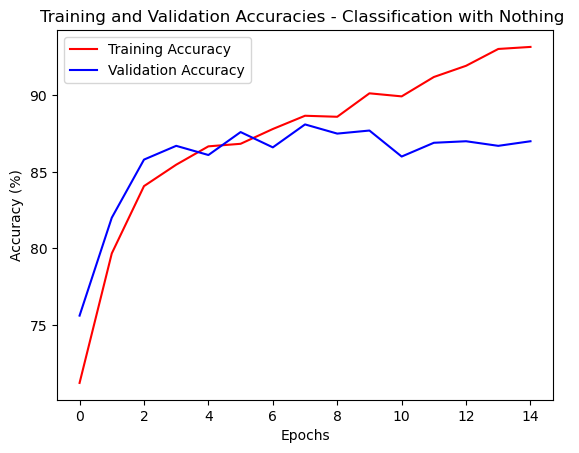

In [17]:
plt.plot(Epoch, train_accuracies, "r", label="Training Accuracy")
plt.plot(Epoch, test_accuracies, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracies - Classification with Nothing ")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [30]:
# 5 class test data prediction 

Test_loss_5_class,Test_accuracy_5_class = predict(test_data_load)

print('Accuracy on 5 class original test data = ',Test_accuracy_5_class)


Accuracy on 5 class original test data =  88.4


In [31]:
# 4 class training

Epochs, train_accuracies_r, train_losses_r, test_accuracies_r, test_losses_r=train_evaluate_model(model = my_model, train_data= train_data_load_r,  valid_data = validation_data_load_r, num_epochs=15)

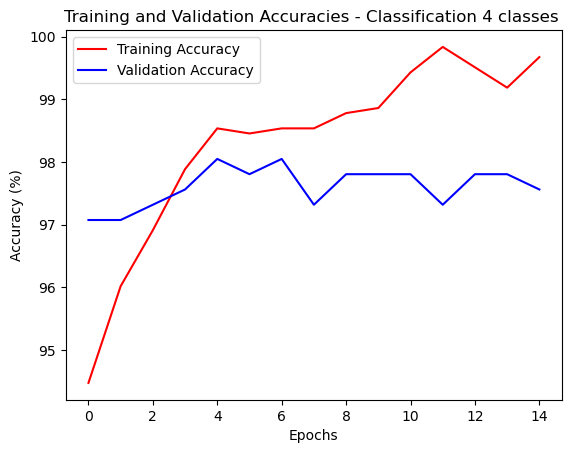

In [32]:
plt.plot(Epochs, train_accuracies_r, "r", label="Training Accuracy")
plt.plot(Epochs, test_accuracies_r, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracies - Classification 4 classes ")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [33]:
# 4 class test data prediction 

Test_loss_4_class,Test_accuracy_4_class = predict(test_data_load_r)

print('Accuracy on 4 class original test data = ',Test_accuracy_4_class)


Accuracy on 4 class original test data =  97.07317073170732


## 2. Data Augmentation for Car Racing

This exercise is an extension of the previous one. The deep neural network has to be trained now with data augmentation. Since we deal with a classification problem, the augmentation is on the image data only. The data split will be the same as above (i.e. 3000 train, 1000 validation and 1000 test samples) and the samples of each set have to be the same too.

*Task Output*: Repeat the training process with data augmentation now. The augmentation should be applied randomly inside the mini-batch loading. Moreover, the augmentations that have to be implemented are horizontal flipping, random crop and rotation (up to 20 degrees). Both models of 5-class and 4-class have to be trained with augmentation. The output of the exercise will be the training, validation and test set figures of loss over time and performance over time. The model has to be trained for at least 15 epochs. Finally, the result of training with and without augmentation should be visualized in the same plot.


In [34]:
# Custom data loader with data augmentation

class customdata_augmentation(Dataset):
    
    def __init__(self, root_dir, history_actions, history_states, data_hflip = False, random_crop =False, random_rotation=False, transform=None):
        

        self.root_dir = root_dir
        self.transform = transform
        self.history_states = history_states
        self.history_actions = history_actions   
        self.data_hflip = data_hflip
        self.random_crop = random_crop
        self.random_rotation = random_rotation
        
    
    def __len__(self):
        
        return len(self.history_actions)
    
    
    def __getitem__(self, idx):
        
        states = self.history_states[idx]
        
        actions = self.history_actions[idx]
        
        

            
         
        if self.data_hflip:
            hflip = torchvision.transforms.RandomHorizontalFlip(p=0.25)
            if isinstance(states, np.ndarray):
                states = Image.fromarray(states)
            states = hflip(states)
            

            
        if self.random_crop:
            rand_crop = torchvision.transforms.RandomCrop((96, 96))
            if isinstance(states, np.ndarray):
                states = Image.fromarray(states)
            states = rand_crop(states)    
        
        




        if self.random_rotation:
            rand_rotate = torchvision.transforms.RandomRotation(degrees=(0, 20))
            if isinstance(states, np.ndarray):
                states = Image.fromarray(states)
            states = rand_rotate(states)
            
        
        
        if self.transform:
            states = self.transform(states)
            
            
        return states,actions
        
        
        
    

In [35]:
# Augmented data for 5class training

aug_train_data = customdata_augmentation(root_dir =root_directory , history_actions= y_train, history_states = x_train, data_hflip = True, random_crop =True, random_rotation=True, transform=transforms.ToTensor())
aug_train_data_load = DataLoader(aug_train_data, batch_size=25, shuffle=False) 



aug_test_data = customdata_augmentation(root_dir =root_directory , history_actions= y_test, history_states = x_test, data_hflip = True, random_crop =True, random_rotation=True , transform=transforms.ToTensor())
aug_test_data_load = DataLoader(aug_test_data, batch_size=25, shuffle=False) 


aug_validation_data = customdata_augmentation(root_dir =root_directory , history_actions= y_validation, history_states = x_validation, data_hflip = True, random_crop =True, random_rotation=True, transform=transforms.ToTensor())
aug_validation_data_load = DataLoader(aug_validation_data, batch_size=25, shuffle=False) 

In [36]:
# Augmented data for 4 class training 

aug_train_data_r = customdata_augmentation(root_dir =root_directory , history_actions= y_train_r, history_states = x_train_r, data_hflip = True, random_crop =True, random_rotation=True, transform=transforms.ToTensor())
aug_train_data_load_r = DataLoader(aug_train_data_r, batch_size=25, shuffle=False) 


aug_test_data_r = customdata_augmentation(root_dir =root_directory , history_actions= y_test_r, history_states = x_test_r, data_hflip = True, random_crop =True, random_rotation=True, transform=transforms.ToTensor())
aug_test_data_load_r = DataLoader(aug_test_data_r, batch_size=25, shuffle=False) 


aug_validation_data_r = customdata_augmentation(root_dir =root_directory , history_actions= y_validation_r, history_states = x_validation_r, data_hflip = True, random_crop =True, random_rotation=True, transform=transforms.ToTensor())
aug_validation_data_load_r = DataLoader(aug_validation_data_r, batch_size=25, shuffle=False) 

In [37]:
# 5 class training with augmented data

aug_epoch,aug_train_accuracies, aug_train_losses, aug_test_accuracies, aug_test_losses=train_evaluate_model(model = my_model, train_data= aug_train_data_load,  valid_data = aug_validation_data_load, num_epochs=15)

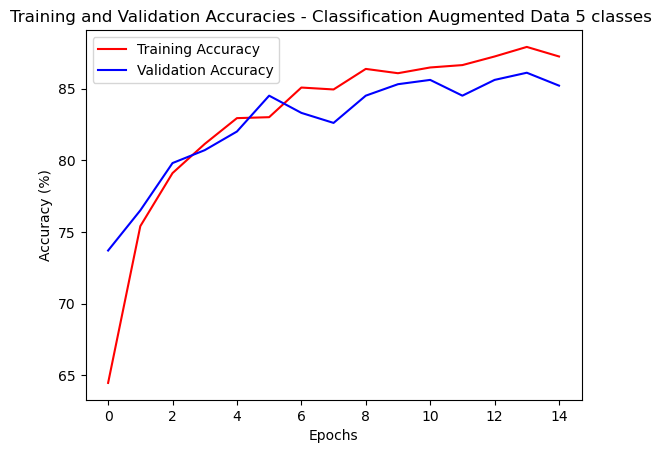

In [38]:
plt.plot(aug_epoch, aug_train_accuracies, "r", label="Training Accuracy")
plt.plot(aug_epoch, aug_test_accuracies, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracies - Classification Augmented Data 5 classes ")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [39]:
# 5 class augmented test data prediction 

Aug_Test_loss_5_class,Aug_Test_accuracy_5_class = predict(aug_test_data_load)



print('Accuracy on 5 class Augmented  test data = ',Aug_Test_accuracy_5_class)



Accuracy on 5 class Augmented  test data =  85.5


In [40]:
# 4 class training with augmented data

aug_epochs,aug_train_accuracies_r, aug_train_losses_r, aug_test_accuracies_r, aug_test_losses_r=train_evaluate_model(model = my_model, train_data= aug_train_data_load_r,  valid_data = aug_validation_data_load_r, num_epochs=15)

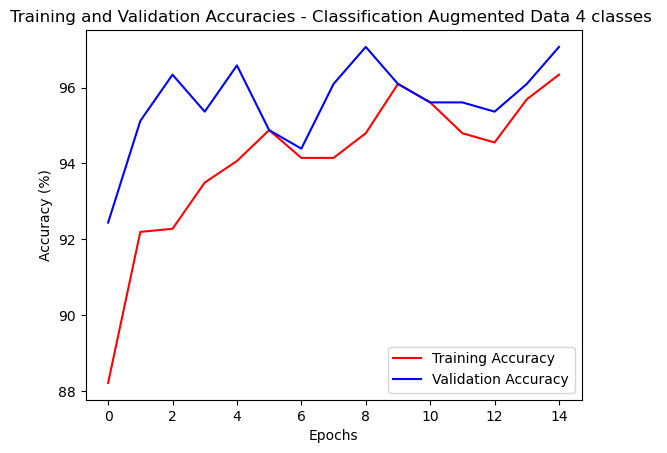

In [41]:
plt.plot(aug_epochs, aug_train_accuracies_r, "r", label="Training Accuracy")
plt.plot(aug_epochs, aug_test_accuracies_r, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracies - Classification Augmented Data 4 classes ")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [42]:
# 4 class augmented test data prediction 

Aug_Test_loss_4_class,Aug_Test_accuracy_4_class = predict(aug_test_data_load_r)



print('Accuracy on 4 class Augmented  test data = ',Aug_Test_accuracy_4_class)

Accuracy on 4 class Augmented  test data =  93.90243902439025


## 3. Mono-Color Training

In this task, the colors input images will be converted to gray-scale. Then the model will be trained on the new input data. The motivation of the exercise is to examine whether the color is not necessary for this exercise.

*Task Output*: Repeat the training process with gray-scale images instead of RGB data. For that purpose, the 5000 images have to be converted into gray-scale off-line or on-line when fetching a mini-batch. The training should be conducted for 5-class and 4-class models, but without augmentation. The output of the exercise will be the training, validation and test set figures of loss over time and performance over time. The model has to be trained for at least 15 epochs. Finally, the result of training with RGB and gray-scale image should be visualized in the same plot.


In [43]:
class customdata_grayscale(Dataset):
    
    def __init__(self, root_dir, history_actions, history_states, transform=None):
        

        self.root_dir = root_dir
        self.transform = transform
        self.history_states = history_states
        self.history_actions = history_actions    
        
    
    def __len__(self):
        
        return len(self.history_actions)
    
    
    def __getitem__(self, idx):
        
        states = self.history_states[idx]
        
        states = cv2.cvtColor(states, cv2.COLOR_BGR2GRAY)
        
        actions = self.history_actions[idx]
        
        if self.transform:
            states = self.transform(states)
            
            
        return states,actions
        
        
        
    

In [44]:
# Grayscale Data for 5 class training 

gray_train_data = customdata_grayscale(root_dir =root_directory , history_actions= y_train, history_states = x_train, transform=transforms.ToTensor())
gray_train_data_load = DataLoader(gray_train_data, batch_size=25, shuffle=False) 


gray_test_data = customdata_grayscale(root_dir =root_directory , history_actions= y_test, history_states = x_test, transform=transforms.ToTensor())
gray_test_data_load = DataLoader(gray_test_data, batch_size=25, shuffle=False) 


gray_validation_data = customdata_grayscale(root_dir =root_directory , history_actions= y_validation, history_states = x_validation, transform=transforms.ToTensor())
gray_validation_data_load = DataLoader(gray_validation_data, batch_size=25, shuffle=False) 

In [45]:
# Greyscal Data for 4 class training 

gray_train_data_r = customdata_grayscale(root_dir =root_directory , history_actions= y_train_r, history_states = x_train_r, transform=transforms.ToTensor())
gray_train_data_load_r = DataLoader(gray_train_data_r, batch_size=25, shuffle=False) 


gray_test_data_r = customdata_grayscale(root_dir =root_directory , history_actions= y_test_r, history_states = x_test_r, transform=transforms.ToTensor())
gray_test_data_load_r = DataLoader(gray_test_data_r, batch_size=25, shuffle=False) 


gray_validation_data_r = customdata_grayscale(root_dir =root_directory , history_actions= y_validation_r, history_states = x_validation_r, transform=transforms.ToTensor())
gray_validation_data_load_r = DataLoader(gray_validation_data_r, batch_size=25, shuffle=False) 

In [46]:
class classifier_grey(torch.nn.Module):
    
    def __init__(self):
        super(classifier_grey,self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(64 * 24 * 24, 128)
        self.fc2 = torch.nn.Linear(128, 5)

        
    def forward(self,x):
        
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 24 * 24)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
        
        


In [47]:
grey_scale = classifier_grey()

In [48]:
# 5 class training with Grayscale data

gray_epoch,gray_train_accuracies, gray_train_losses, gray_test_accuracies, gray_test_losses=train_evaluate_model(model = grey_scale, train_data= gray_train_data_load,  valid_data = gray_validation_data_load, num_epochs=15)

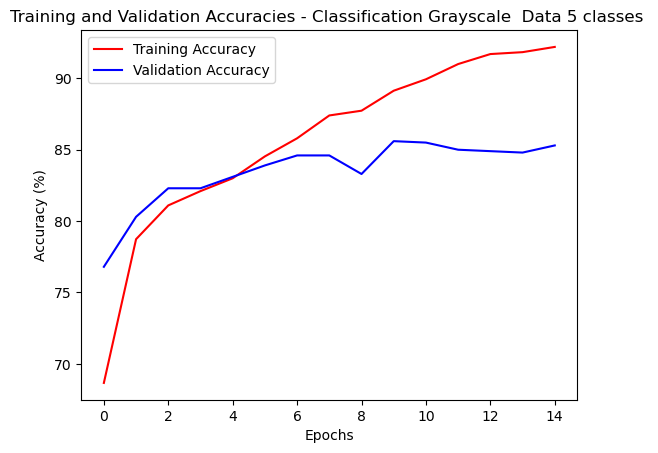

In [52]:
plt.plot(gray_epoch, gray_train_accuracies, "r", label="Training Accuracy")
plt.plot(gray_epoch, gray_test_accuracies, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracies - Classification Grayscale  Data 5 classes ")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [53]:
# 5 class Grayscale test data prediction 

gray_Test_loss_5_class,gray_Test_accuracy_5_class =predict(test_data = gray_test_data_load, model=grey_scale, criterion = torch.nn.CrossEntropyLoss())

print('Accuracy on 5 class Grayscale  test data = ',gray_Test_accuracy_5_class)


Accuracy on 5 class Grayscale  test data =  87.1


In [54]:
# 4 class training with augmented data

gray_epochs,gray_train_accuracies_r, gray_train_losses_r, gray_test_accuracies_r, gray_test_losses_r =train_evaluate_model(model = grey_scale, train_data= gray_train_data_load,  valid_data = gray_validation_data_load, num_epochs=15)

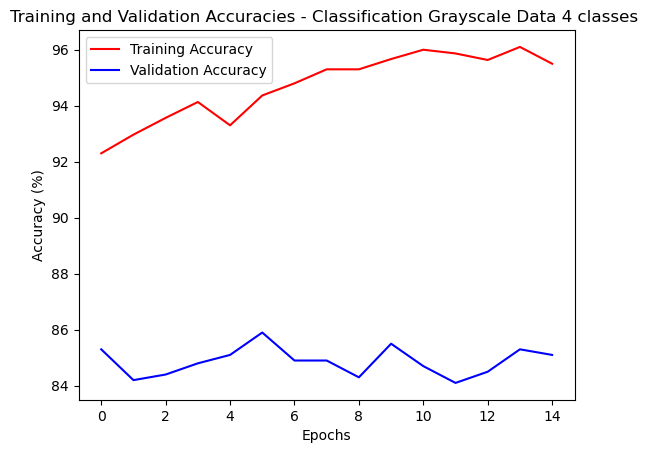

In [55]:
plt.plot(gray_epochs, gray_train_accuracies_r, "r", label="Training Accuracy")
plt.plot(gray_epochs, gray_test_accuracies_r, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracies - Classification Grayscale Data 4 classes ")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [56]:
# 4 class Grayscale test data prediction 

gray_Test_loss_4_class,gray_Test_accuracy_4_class = predict(test_data = gray_test_data_load_r, model=grey_scale, criterion = torch.nn.CrossEntropyLoss())

print('Accuracy on 4 class Grayscale  test data = ',gray_Test_accuracy_4_class)


Accuracy on 4 class Grayscale  test data =  81.95121951219512
